# Introduction

The majority of this notebook was retrived from Ashish Gupta's kernel: https://www.kaggle.com/roydatascience/elo-merchant-recommendation-fathers-day-specials



## Python libraries needed

* [Anaconda](https://anaconda.org)
* [XGBoost](https://github.com/dmlc/xgboost)
* [LightGBM](https://github.com/Microsoft/LightGBM) - not needed by week 1
* [Keras](https://keras.io) - not needed by week 1
* [Tensorflow](https://www.tensorflow.org) - not needed by week 1
* [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization) - not needed by week 1
* [seaborn](https://seaborn.pydata.org)
* [bokeh](http://bokeh.pydata.org)


## Local directory
If you want to run it locally the following directory structure is recommended:

```
elo-merchant-category-recommendation
└───python
│   │   your.ipynb
│   │   ...
└───input
│   │   train.csv
│   │   test.csv
> │   │   ...
└───output
    │   submission.csv
    │   ...
    

In [1]:
## Data manipulation
import numpy as np
import pandas as pd

## Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
plt.style.use('seaborn')


## Modelling
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge,ElasticNet, SGDRegressor
from scipy import sparse
from scipy.stats import norm, skew


## Others
import os
import time
import datetime
import warnings
import gc
import os
import pickle
from six.moves import urllib
import warnings
warnings.filterwarnings('ignore')


/Users/yurungu/anaconda2/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Data preprocessing

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_hist_trans = pd.read_csv('historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('new_merchant_transactions.csv')

In [7]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [6]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [8]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

# Feature engineering
Given that we are working largely on transactional data so the key to feature engineering for this competitin is how to appropriately aggregate transactions to card level and essentially 

1. How can we aggregate numerical features?
2. How can we aggregate cateogrical features?
3. Do we need to use different statistical metrics for different features? Why? How can we find the appropriate metrics?
4. How to generate feature interactions?


## Aggregate history transations

In [13]:
df_hist_trans.head(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,subsector_id,year,weekofyear,month,dayofweek,weekend,hour,month_diff,category_2_mean,category_3_mean
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,...,37,2017,25,6,6,1,15,10,0.074568,0.358458
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,...,16,2017,28,7,5,1,12,10,0.074568,0.358458
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,...,37,2017,32,8,2,0,22,11,0.074568,0.358458
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,...,34,2017,35,9,5,1,10,11,0.074568,0.358458
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,...,37,2017,10,3,4,0,1,11,0.074568,0.358458
5,1,C_ID_4e6213e9bc,333,0,0,A,80,M_ID_50af771f8d,0,-0.734887,...,37,2018,8,2,5,1,8,10,0.074568,0.358458
6,1,C_ID_4e6213e9bc,88,0,0,A,278,M_ID_5e8220e564,-11,-0.716855,...,37,2017,12,3,1,0,0,10,0.074568,0.358458
7,1,C_ID_4e6213e9bc,3,0,0,A,80,M_ID_9d41786a50,-3,-0.657049,...,37,2017,46,11,5,1,20,10,0.074568,0.358458
8,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-8,-0.737967,...,37,2017,22,6,3,0,22,11,0.074568,0.358458
9,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_74ba14b5fc,-11,-0.715352,...,37,2017,11,3,3,0,15,11,0.074568,0.358458


In [17]:
#to create a skeleton
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

print(aggs)

{'month': ['nunique'], 'hour': ['nunique'], 'weekofyear': ['nunique'], 'dayofweek': ['nunique'], 'year': ['nunique'], 'subsector_id': ['nunique'], 'merchant_id': ['nunique'], 'merchant_category_id': ['nunique'], 'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'], 'installments': ['sum', 'max', 'min', 'mean', 'var'], 'purchase_date': ['max', 'min'], 'month_lag': ['max', 'min', 'mean', 'var'], 'month_diff': ['mean'], 'authorized_flag': ['sum', 'mean'], 'weekend': ['sum', 'mean'], 'category_1': ['sum', 'mean'], 'card_id': ['size']}


In [9]:
for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

42

## Aggregate new transactions

In [10]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [11]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

## Create hist-new interacations

In [15]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_hist_first_buy,card_id_total,purchase_amount_total
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820283,9,23,35,7,...,251.0,0,3,22,6,583,26,277.0,283.0,-179.212942
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392913,12,24,50,7,...,281.0,0,6,52,1,734,5,396.0,356.0,-214.362071
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.688056,10,14,22,7,...,251.0,0,0,31,8,887,163,635.0,44.0,-29.867717
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142495,6,16,20,7,...,262.0,0,4,35,9,491,25,187.0,84.0,-54.145736
4,2017-11-01,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,-0.159749,4,22,17,7,...,251.0,0,2,44,11,430,11,121.0,169.0,-68.613893


In [12]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)


# Training the model

Here we will be using a technique called "stacking" to train the model. We will take a dive into stacking in week 3 and for now you can just think it as a normal training-predicting process.

In [14]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']

In [18]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.37253	valid_1's rmse: 3.65554
Early stopping, best iteration is:
[1263]	training's rmse: 3.33179	valid_1's rmse: 3.65459
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.3694	valid_1's rmse: 3.65717
Early stopping, best iteration is:
[1457]	training's rmse: 3.29795	valid_1's rmse: 3.65516
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.37292	valid_1's rmse: 3.65508
Early stopping, best iteration is:
[1381]	training's rmse: 3.31416	valid_1's rmse: 3.65348
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.36935	valid_1's rmse: 3.65936
Early stopping, best iteration is:
[1460]	training's rmse: 3.29935	valid_1's rmse: 3.6566
fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.36854	valid_1's rmse: 3.64933
Early st

3.6538227190800465

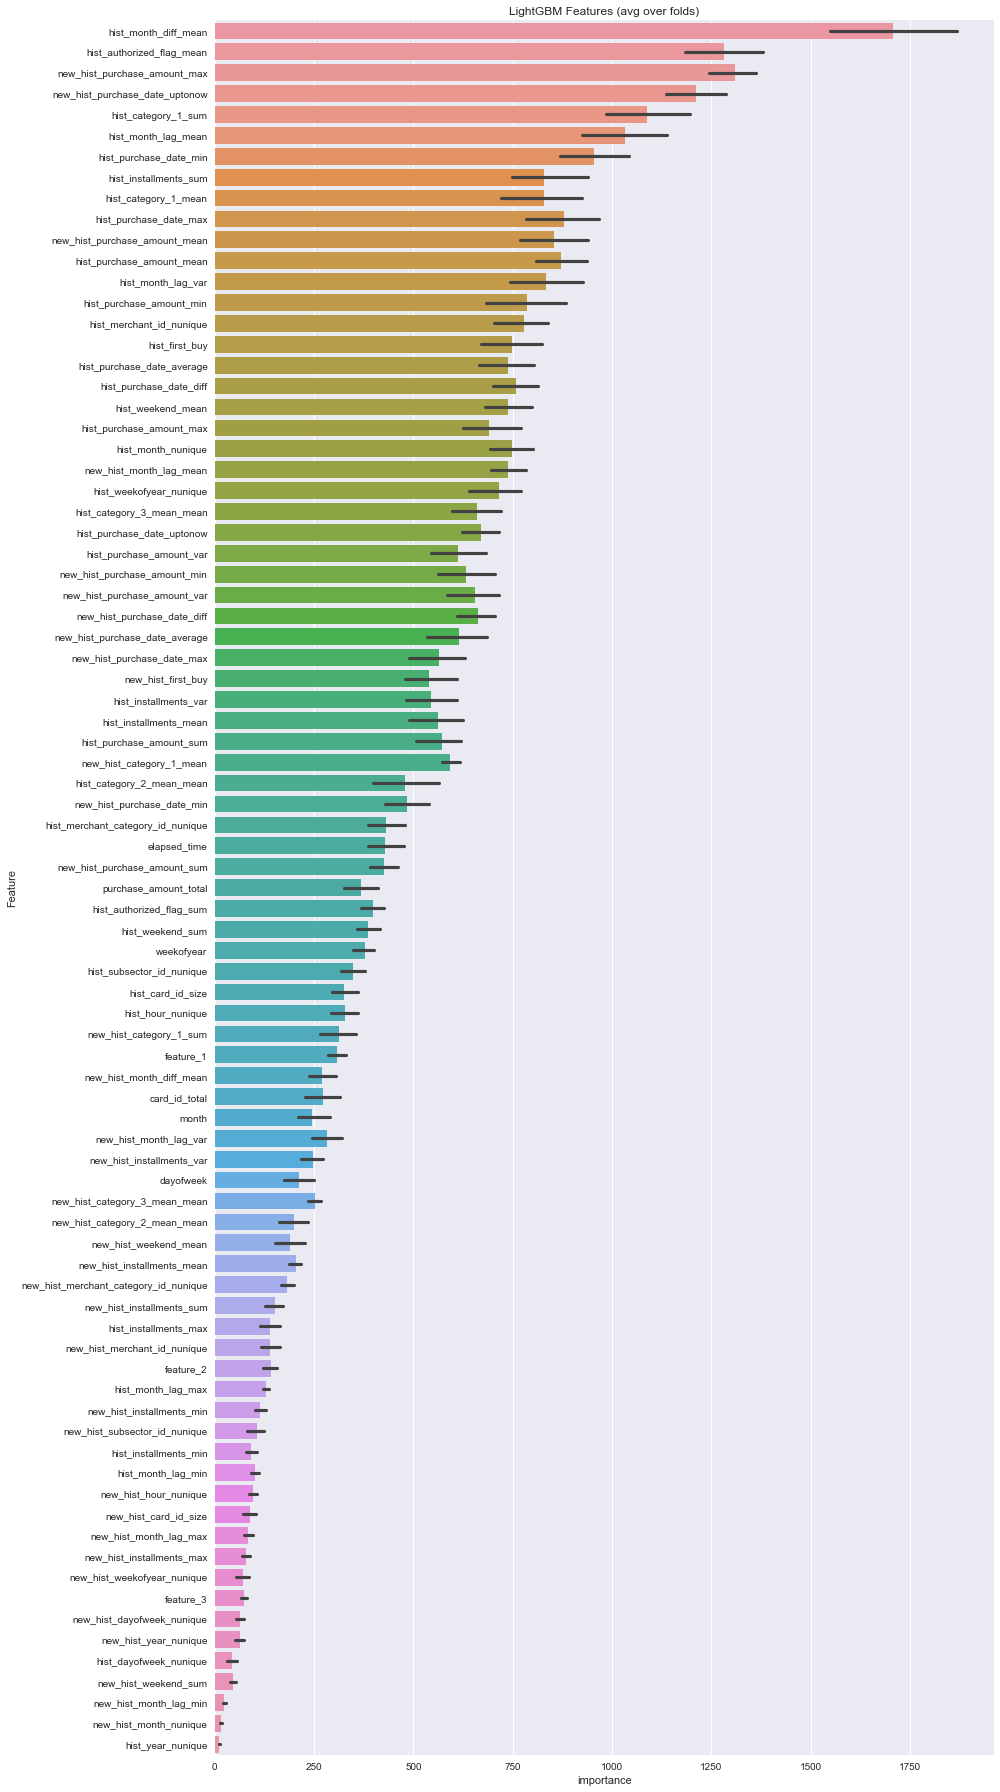

In [12]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [13]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_starter.csv", index=False)

# Additional feature engineerings

### Generating finer aggregations using pandas pivot table

In [19]:
df_hist_pivot = df_hist_trans.pivot_table(index='card_id', columns='month_lag', values='merchant_id', aggfunc='count')
df_hist_pivot.columns = ['hist_tran_count_month_lag_' + str(c) for c in df_hist_pivot.columns]
hist_month_lag_count_columns = list(df_hist_pivot.columns)
df_hist_pivot = df_hist_pivot.reset_index()
df_hist_pivot.head()

,card_id,hist_tran_count_month_lag_-13,hist_tran_count_month_lag_-12,hist_tran_count_month_lag_-11,hist_tran_count_month_lag_-10,hist_tran_count_month_lag_-9,hist_tran_count_month_lag_-8,hist_tran_count_month_lag_-7,hist_tran_count_month_lag_-6,hist_tran_count_month_lag_-5,hist_tran_count_month_lag_-4,hist_tran_count_month_lag_-3,hist_tran_count_month_lag_-2,hist_tran_count_month_lag_-1,hist_tran_count_month_lag_0
0,C_ID_00007093c1,NaN,4.0,10.0,12.0,10.0,19.0,15.0,17.0,5.0,17.0,6.0,12.0,10.0,12.0
1,C_ID_0001238066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,11.0,23.0,37.0,26.0,24.0
2,C_ID_0001506ef0,2.0,5.0,8.0,NaN,1.0,3.0,2.0,2.0,2.0,3.0,7.0,18.0,7.0,6.0
3,C_ID_0001793786,NaN,NaN,NaN,NaN,2.0,6.0,16.0,30.0,4.0,37.0,29.0,34.0,38.0,20.0
4,C_ID_000183fdda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,22.0,25.0,9.0,26.0,28.0,28.0


In [20]:
df_train = df_train.merge(df_hist_pivot,on='card_id',how='left')
df_test = df_test.merge(df_hist_pivot,on='card_id',how='left')
print (df_train.shape, df_test.shape)

(201917, 101) (123623, 99)


In [16]:
del df_hist_pivot
gc.collect()

17288

Let's rerun the model with newly added features:

In [21]:
df_train_columns = ['feature_1',
                    'feature_2',
                    'feature_3',
                    'hist_month_nunique',
                    'hist_hour_nunique',
                    'hist_weekofyear_nunique',
                    'hist_dayofweek_nunique',
                    'hist_year_nunique',
                    'hist_subsector_id_nunique',
                    'hist_merchant_id_nunique',
                    'hist_merchant_category_id_nunique',
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_mean',
                    'hist_purchase_amount_var',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_mean',
                    'hist_installments_var',
                    'hist_purchase_date_max',
                    'hist_purchase_date_min',
                    'hist_month_lag_max',
                    'hist_month_lag_min',
                    'hist_month_lag_mean',
                    'hist_month_lag_var',
                    'hist_month_diff_mean',
                    'hist_authorized_flag_sum',
                    'hist_authorized_flag_mean',
                    'hist_weekend_sum',
                    'hist_weekend_mean',
                    'hist_category_1_sum',
                    'hist_category_1_mean',
                    'hist_card_id_size',
                    'hist_category_2_mean_mean',
                    'hist_category_3_mean_mean',
                    'hist_purchase_date_diff',
                    'hist_purchase_date_average',
                    'hist_purchase_date_uptonow',
                    'new_hist_month_nunique',
                    'new_hist_hour_nunique',
                    'new_hist_weekofyear_nunique',
                    'new_hist_dayofweek_nunique',
                    'new_hist_year_nunique',
                    'new_hist_subsector_id_nunique',
                    'new_hist_merchant_id_nunique',
                    'new_hist_merchant_category_id_nunique',
                    'new_hist_purchase_amount_sum',
                    'new_hist_purchase_amount_max',
                    'new_hist_purchase_amount_min',
                    'new_hist_purchase_amount_mean',
                    'new_hist_purchase_amount_var',
                    'new_hist_installments_sum',
                    'new_hist_installments_max',
                    'new_hist_installments_min',
                    'new_hist_installments_mean',
                    'new_hist_installments_var',
                    'new_hist_purchase_date_max',
                    'new_hist_purchase_date_min',
                    'new_hist_month_lag_max',
                    'new_hist_month_lag_min',
                    'new_hist_month_lag_mean',
                    'new_hist_month_lag_var',
                    'new_hist_month_diff_mean',
                    'new_hist_weekend_sum',
                    'new_hist_weekend_mean',
                    'new_hist_category_1_sum',
                    'new_hist_category_1_mean',
                    'new_hist_card_id_size',
                    'new_hist_category_2_mean_mean',
                    'new_hist_category_3_mean_mean',
                    'new_hist_purchase_date_diff',
                    'new_hist_purchase_date_average',
                    'new_hist_purchase_date_uptonow',
                    'dayofweek',
                    'weekofyear',
                    'month',
                    'elapsed_time',
                    'hist_first_buy',
                    'new_hist_first_buy',
                    'card_id_total',
                    'purchase_amount_total'] + hist_month_lag_count_columns

In [18]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.35559	valid_1's rmse: 3.65601
Early stopping, best iteration is:
[1348]	training's rmse: 3.29667	valid_1's rmse: 3.65508
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.35105	valid_1's rmse: 3.65186
Early stopping, best iteration is:
[1496]	training's rmse: 3.26561	valid_1's rmse: 3.64949
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.3551	valid_1's rmse: 3.65142
Early stopping, best iteration is:
[1614]	training's rmse: 3.25757	valid_1's rmse: 3.64929
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.35436	valid_1's rmse: 3.65401
Early stopping, best iteration is:
[1680]	training's rmse: 3.24955	valid_1's rmse: 3.65037
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[823]	training's rmse: 3.385

3.6519040339294375

In [19]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_1.csv", index=False)

## Aggregate categorical features in transactions with NLP embedding

In [22]:
df_hist_tran_as_sentence = df_hist_trans[['card_id','merchant_id']].astype('unicode').fillna('None')\
        .groupby('card_id')['merchant_id'].apply(list).apply(lambda x: ','.join(x)).reset_index()

In [23]:
encoder = CountVectorizer(tokenizer=lambda x: x.split(','))
topic_sparse = encoder.fit_transform(df_hist_tran_as_sentence['merchant_id'].values)
decomposer = TruncatedSVD(n_components=10)
topic_matrix = decomposer.fit_transform(topic_sparse)

df_hist_tfidf = pd.DataFrame(topic_matrix, columns=['tfidf_' + 'merchant_id' + '_' + str(i) for i in range(10)])
tfidf_hist_merchant_columns = list(df_hist_tfidf.columns)
df_hist_tfidf['card_id'] = df_hist_tran_as_sentence['card_id']

In [24]:
df_train = df_train.merge(df_hist_tfidf,on='card_id',how='left')
df_test = df_test.merge(df_hist_tfidf,on='card_id',how='left')
print (df_train.shape, df_test.shape)

del df_hist_tfidf
gc.collect(0)

(201917, 111) (123623, 109)


42

In [25]:
df_train_columns = ['feature_1',
                    'feature_2',
                    'feature_3',
                    'hist_month_nunique',
                    'hist_hour_nunique',
                    'hist_weekofyear_nunique',
                    'hist_dayofweek_nunique',
                    'hist_year_nunique',
                    'hist_subsector_id_nunique',
                    'hist_merchant_id_nunique',
                    'hist_merchant_category_id_nunique',
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_mean',
                    'hist_purchase_amount_var',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_mean',
                    'hist_installments_var',
                    'hist_purchase_date_max',
                    'hist_purchase_date_min',
                    'hist_month_lag_max',
                    'hist_month_lag_min',
                    'hist_month_lag_mean',
                    'hist_month_lag_var',
                    'hist_month_diff_mean',
                    'hist_authorized_flag_sum',
                    'hist_authorized_flag_mean',
                    'hist_weekend_sum',
                    'hist_weekend_mean',
                    'hist_category_1_sum',
                    'hist_category_1_mean',
                    'hist_card_id_size',
                    'hist_category_2_mean_mean',
                    'hist_category_3_mean_mean',
                    'hist_purchase_date_diff',
                    'hist_purchase_date_average',
                    'hist_purchase_date_uptonow',
                    'new_hist_month_nunique',
                    'new_hist_hour_nunique',
                    'new_hist_weekofyear_nunique',
                    'new_hist_dayofweek_nunique',
                    'new_hist_year_nunique',
                    'new_hist_subsector_id_nunique',
                    'new_hist_merchant_id_nunique',
                    'new_hist_merchant_category_id_nunique',
                    'new_hist_purchase_amount_sum',
                    'new_hist_purchase_amount_max',
                    'new_hist_purchase_amount_min',
                    'new_hist_purchase_amount_mean',
                    'new_hist_purchase_amount_var',
                    'new_hist_installments_sum',
                    'new_hist_installments_max',
                    'new_hist_installments_min',
                    'new_hist_installments_mean',
                    'new_hist_installments_var',
                    'new_hist_purchase_date_max',
                    'new_hist_purchase_date_min',
                    'new_hist_month_lag_max',
                    'new_hist_month_lag_min',
                    'new_hist_month_lag_mean',
                    'new_hist_month_lag_var',
                    'new_hist_month_diff_mean',
                    'new_hist_weekend_sum',
                    'new_hist_weekend_mean',
                    'new_hist_category_1_sum',
                    'new_hist_category_1_mean',
                    'new_hist_card_id_size',
                    'new_hist_category_2_mean_mean',
                    'new_hist_category_3_mean_mean',
                    'new_hist_purchase_date_diff',
                    'new_hist_purchase_date_average',
                    'new_hist_purchase_date_uptonow',
                    'dayofweek',
                    'weekofyear',
                    'month',
                    'elapsed_time',
                    'hist_first_buy',
                    'new_hist_first_buy',
                    'card_id_total',
                    'purchase_amount_total'] + hist_month_lag_count_columns + tfidf_hist_merchant_columns

In [24]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34352	valid_1's rmse: 3.6536
Early stopping, best iteration is:
[1384]	training's rmse: 3.27645	valid_1's rmse: 3.65177
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33938	valid_1's rmse: 3.65188
Early stopping, best iteration is:
[968]	training's rmse: 3.34584	valid_1's rmse: 3.6516
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34148	valid_1's rmse: 3.64647
Early stopping, best iteration is:
[1757]	training's rmse: 3.21869	valid_1's rmse: 3.64321
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34193	valid_1's rmse: 3.6539
Early stopping, best iteration is:
[1572]	training's rmse: 3.24688	valid_1's rmse: 3.65008
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[881]	training's rmse: 3.35975	

3.6496305891595258

In [25]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_2.csv", index=False)

## Food for thoughts

There are a few thoughts that might be the key to success for this competition:

1. Outliers
    *     The majority of RMSE was contributed by outliers. How can we handle or leverage it? 
    *     What could the outliers actually be?
    *     Can we use any stratrified cv method?
2.  Month lag
    *     What does "month lag" mean? 
    *     Why it appears to be important?
    *     How can we leverage it?
3.  Installments
    *     What does "installments" mean? 
    *     How can we leverage it?
    *     What does installment interact with other features such as month lag, cateogrical 3 etc?
4. Purchase amount
    *     Why purchase amount can be negative?
    *     Why there are a lot of positive outliers on purchase amount?
    *     Why it's not as important as expected?
5.   New vs history transactions
    *   Why there's no overlap between history and new transactions? 
    *   What could be the relationship between history and new transactions?
   
   

# Parameter tuning

## LightGBM

### Manual tuning

* Find the best value for a parameter then move to the next one.
* Repeat the process for all the parameters we want to tune.
* Tuning with a larger learning rate 0.1

In [26]:
train_x = df_train[df_train_columns].values
train_y = target.values
test_x = df_train[df_train_columns].values
train_kfold_y = df_train['outliers'].values

In [27]:
import copy
default_lgb_params = {}
default_lgb_params["learning_rate"] = 0.05
default_lgb_params["metric"] = 'rmse'
default_lgb_params["bagging_freq"] = 1
default_lgb_params["seed"] = 1234
default_lgb_params["objective"] = "regression"
default_lgb_params["n_jobs"] = 8

params_lgb_space = {}
params_lgb_space['num_leaves'] = [3, 7, 15, 31, 63, 127, 255]
params_lgb_space['max_depth'] = [3, 5, 7, 10, 15, 30, -1]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['feature_fraction'] = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
params_lgb_space['bagging_fraction'] = [0.6, 0.7, 0.8, 0.9, 0.95, 1]
params_lgb_space['min_sum_hessian_in_leaf'] = [1, 5, 10, 30, 100]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100, 300]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10, 100, 300]


greater_is_better = False

best_lgb_params = copy.copy(default_lgb_params)

for p in params_lgb_space:
    print ("\n Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v
        lgb_cv = lgb.cv(params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                folds=folds.split(train_x,train_kfold_y),## stratified kfolds based on outliers flag
                early_stopping_rounds=100,
                verbose_eval=-1)

        best_lgb_score = min(lgb_cv['rmse-mean'])
        best_lgb_iteration = len(lgb_cv['rmse-mean'])
        print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))
        scores.append([v, best_lgb_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('\n Best manually tuned parameters:', best_lgb_params)   

best_manual_lgb_params = copy.copy(best_lgb_params)


 Tuning parameter num_leaves in [3, 7, 15, 31, 63, 127, 255]

    num_leaves: 3
, best_score: 3.681311, best_iteration: 2921

    num_leaves: 7
, best_score: 3.660112, best_iteration: 1054

    num_leaves: 15
, best_score: 3.659817, best_iteration: 324

    num_leaves: 31
, best_score: 3.659008, best_iteration: 249

    num_leaves: 63
, best_score: 3.664863, best_iteration: 136

    num_leaves: 127
, best_score: 3.664902, best_iteration: 90

    num_leaves: 255
, best_score: 3.677182, best_iteration: 65
Best num_leaves is 31 with a score of 3.659008

 Tuning parameter max_depth in [3, 5, 7, 10, 15, 30, -1]

    max_depth: 3
, best_score: 3.667162, best_iteration: 915

    max_depth: 5
, best_score: 3.656278, best_iteration: 233

    max_depth: 7
, best_score: 3.655931, best_iteration: 163

    max_depth: 10
, best_score: 3.658059, best_iteration: 154

    max_depth: 15
, best_score: 3.657350, best_iteration: 278

    max_depth: 30
, best_score: 3.659008, best_iteration: 249

    max_d

### Auto tuning

We will be using a package BayesianOptimization for automated tuning. Results from manual tuning can be used to further narrow the space that needs to be searched from for better performance. 

Visit https://github.com/fmfn/BayesianOptimization for more details about Bayesian Optimization.

In [33]:
from bayes_opt import BayesianOptimization


def lgb_evaluate(
    num_leaves,
    max_depth,
    min_sum_hessian_in_leaf,
    min_gain_to_split,
    feature_fraction,
    bagging_fraction,
    lambda_l2,
    lambda_l1
):
    params = dict()
    params['objective'] = 'regression'
    params['learning_rate'] = 0.05
    params['seed'] = 1234
    params['num_leaves'] = int(num_leaves)
    params['max_depth'] = int(max_depth)
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['min_gain_to_split'] = min_gain_to_split
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = 1
    params['lambda_l2'] = lambda_l2
    params['lambda_l1'] = lambda_l1
    params["metric"] = 'rmse'
    params["n_jobs"] = 8

    lgb_cv = lgb.cv(params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                folds=folds.split(train_x,train_kfold_y),## stratified kfolds based on outliers flag
                early_stopping_rounds=100,
                verbose_eval=-1)

    best_lgb_score = min(lgb_cv['rmse-mean'])
    best_lgb_iteration = len(lgb_cv['rmse-mean'])
    print(', best_score: %f, best_iteration: %d' %
          (best_lgb_score, best_lgb_iteration))

    return -best_lgb_score


lgb_BO = BayesianOptimization(lgb_evaluate,
                               {
                                  'num_leaves': (5, 30),
                                  'max_depth': (3, 15),
                                  'min_sum_hessian_in_leaf': (10, 300),
                                  'min_gain_to_split': (1, 10),
                                  'feature_fraction': (0.6, 1),
                                  'bagging_fraction': (0.6, 1),
                                  'lambda_l2': (100, 500),
                                  'lambda_l1': (0, 50)
                              }
                              )

lgb_BO.maximize(init_points=5, n_iter=40)

Initialization
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves | 
, best_score: 3.647610, best_iteration: 665
    1 | 00m38s |   -3.64761 |             0.9247 |             0.7935 |     25.9347 |    424.6334 |     14.9598 |              2.8934 |                  261.3086 |      19.9064 | 
, best_score: 3.647508, best_iteration: 965
    2 | 00m42s |   -3.64751 |             0.8009 |             0.9694 |     29.5086 |    168.4595 |     10.5229 |              5.8502 |                  248.3911 |       9.7282 | 
, best_score: 3.649032, best_iteration: 440
    3 | 00m25s |   -3.64903 |             0.6032 |             0.6784 |     48.2397 |    383.2992 |     11.4533 |              7.2229 

, best_score: 3.649315, best_iteration: 290
   33 | 00m40s |   -3.64931 |             0.6139 |             0.9886 |     37.2818 |    206.8026 |     14.9343 |              1.0562 |                  212.8627 |      29.3566 | 
, best_score: 3.648593, best_iteration: 400
   34 | 00m38s |   -3.64859 |             0.7223 |             0.6258 |     47.9470 |    376.0271 |     14.6358 |              9.7137 |                  227.0989 |      29.3797 | 
, best_score: 3.650949, best_iteration: 1769
   35 | 01m03s |   -3.65095 |             0.7653 |             0.7326 |      1.0479 |    265.5392 |     14.9156 |              7.3356 |                   83.9233 |       5.5034 | 
, best_score: 3.650045, best_iteration: 409
   36 | 00m54s |   -3.65005 |             0.9896 |             0.9790 |      6.7795 |    143.8659 |     14.6023 |              1.8823 |                   22.7511 |      28.8701 | 
, best_score: 3.648323, best_iteration: 904
   37 | 00m53s |   -3.64832 |             0.6966 |         

#### Results of auto tuning:

In [34]:
# gc.collect()

lgb_BO_scores = pd.DataFrame(lgb_BO.res['all']['params'])
lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res['all']['values'])
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)

lgb_BO_scores.to_csv("../python/tuned_lgb_parameters.csv", index=False)
lgb_BO_scores.head()

,bagging_fraction,feature_fraction,lambda_l1,lambda_l2,max_depth,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,score
8,0.947570,0.843669,2.047843,315.649431,14.951110,8.908745,126.633437,29.317638,-3.645446
23,0.984434,0.623695,48.644871,495.768962,14.682210,1.643156,261.199928,29.256036,-3.646536
14,0.944607,0.822274,49.623750,498.991242,14.519697,5.870146,12.196652,28.102246,-3.646728
26,0.799356,0.957321,41.520483,235.406177,14.551647,9.448550,10.285932,29.215174,-3.646732
25,0.924920,0.838093,0.480310,307.212086,14.856124,1.331801,13.472388,23.800770,-3.646784


### Retrain the model with smaller learning rate

In [35]:
params = lgb_BO_scores.iloc[0].to_dict()
best_lgb_params = dict()
best_lgb_params['objective'] = 'regression'
best_lgb_params["metric"] = 'rmse'
best_lgb_params['learning_rate'] = 0.01 # Smaller learning rate
best_lgb_params['num_leaves'] = int(params['num_leaves'])    
best_lgb_params['max_depth'] = int(params['max_depth'])    
best_lgb_params['min_sum_hessian_in_leaf'] = params['min_sum_hessian_in_leaf']
best_lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
best_lgb_params['feature_fraction'] = params['feature_fraction']
best_lgb_params['bagging_fraction'] = params['bagging_fraction']
best_lgb_params['bagging_freq'] = 1
best_lgb_params['lambda_l2'] = params['lambda_l2']
best_lgb_params['lambda_l1'] = params['lambda_l1']
best_lgb_params['random_state'] = 4590
best_lgb_params["n_jobs"] = 8



folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(best_lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.53664	valid_1's rmse: 3.64692
[2000]	training's rmse: 3.45399	valid_1's rmse: 3.64284
Early stopping, best iteration is:
[2395]	training's rmse: 3.4253	valid_1's rmse: 3.6418
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.53627	valid_1's rmse: 3.64734
[2000]	training's rmse: 3.45469	valid_1's rmse: 3.64349
Early stopping, best iteration is:
[1947]	training's rmse: 3.45848	valid_1's rmse: 3.64333
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.53403	valid_1's rmse: 3.64714
[2000]	training's rmse: 3.45328	valid_1's rmse: 3.64077
Early stopping, best iteration is:
[2220]	training's rmse: 3.43751	valid_1's rmse: 3.64037
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.53308	valid_1's rmse: 3.65318
[2000]	training's rmse: 3.45433	valid_1's rmse: 3.64562
[

3.6438390312666034

In [37]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("sub_lgb_tuned.csv", index=False)

## XGBoost

### Manual tuning

In [46]:
import xgboost as xgb
default_xgb_params = {}
default_xgb_params["objective"] = "reg:linear"
default_xgb_params["eta"] = 0.05
default_xgb_params["seed"] = 1234

params_xgb_space = {}
params_xgb_space['max_depth'] = [4, 5, 6, 7, 8, 9, 10]
params_xgb_space['gamma'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_xgb_space['colsample_bytree'] = [
    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['subsample'] = [
    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['min_child_weight'] = [0, 1, 3, 10, 30, 100]
params_xgb_space['reg_lambda'] = [0, 0.01, 0.1, 1, 10, 100, 300]
params_xgb_space['reg_alpha'] = [0, 0.01, 0.1, 1, 10, 100]

greater_is_better = False

xgtrain = xgb.DMatrix(train_x, label=train_y)
kfolds_list = [(i[0], i[1]) for i in folds.split(train_x, train_kfold_y)]

best_xgb_params = default_xgb_params
for p in params_xgb_space:
    print("Tuning parameter %s in %s" % (p, params_xgb_space[p]))

    params = best_xgb_params
    scores = []
    for v in params_xgb_space[p]:
        print('    %s: %s' % (p, v), end="")
        params[p] = v
        cv_results = xgb.cv(params,
                            xgtrain,
                            stratified=False,
                            folds=kfolds_list,
                            num_boost_round=100000,
                            early_stopping_rounds=100,
                            verbose_eval=False)
        best_iteration = len(cv_results)
        best_score = cv_results['test-rmse-mean'].min()
        print(', best_score: %f, best_iteration: %d' %
              (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(
        scores, key=lambda x: x[1], reverse=greater_is_better)[0][0]
    best_param_score = sorted(
        scores, key=lambda x: x[1], reverse=greater_is_better)[0][1]
    best_xgb_params[p] = best_param_value
    print("Best %s is %s with a score of %f" %
          (p, best_param_value, best_param_score))

Tuning parameter max_depth in [4, 5, 6, 7, 8, 9, 10]
    max_depth: 4, best_score: 3.666444, best_iteration: 346
    max_depth: 5, best_score: 3.659723, best_iteration: 211
    max_depth: 6, best_score: 3.659962, best_iteration: 149
    max_depth: 7, best_score: 3.660746, best_iteration: 155
    max_depth: 8, best_score: 3.667699, best_iteration: 103
    max_depth: 9, best_score: 3.675081, best_iteration: 77
    max_depth: 10, best_score: 3.683763, best_iteration: 59
Best max_depth is 5 with a score of 3.659723
Tuning parameter gamma in [0, 0.1, 0.3, 1, 1.5, 2, 3]
    gamma: 0, best_score: 3.659723, best_iteration: 211
    gamma: 0.1, best_score: 3.659208, best_iteration: 268
    gamma: 0.3, best_score: 3.659952, best_iteration: 241
    gamma: 1, best_score: 3.659125, best_iteration: 252
    gamma: 1.5, best_score: 3.658957, best_iteration: 274
    gamma: 2, best_score: 3.659547, best_iteration: 247
    gamma: 3, best_score: 3.659136, best_iteration: 228
Best gamma is 1.5 with a score 

In [47]:
print ('\n Best manually tuned parameters:', best_xgb_params)   

best_manual_xgb_params = copy.copy(best_xgb_params)


 Best manually tuned parameters: {'objective': 'reg:linear', 'eta': 0.05, 'seed': 1234, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.5, 'subsample': 1, 'min_child_weight': 100, 'reg_lambda': 300, 'reg_alpha': 10}


### Auto tuning

In [ ]:
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 reg_lambda,
                 reg_alpha):
    params = dict()
    params['objective'] = 'reg:linear'
    params['eta'] = 0.05
    params['max_depth'] = int(max_depth)
    params['min_child_weight'] = min_child_weight
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['reg_lambda'] = reg_lambda
    params['reg_alpha'] = reg_alpha
    params['seed'] = 1234

    cv_results = xgb.cv(params,
                        xgtrain,
                        stratified=False,
                        folds=kfolds_list,
                        num_boost_round=100000,
                        early_stopping_rounds=100,
                        verbose_eval=False)
    best_iteration = len(cv_results)
    best_score = cv_results['test-rmse-mean'].min()

    print(', best_score: %f, best_iteration: %d' %
          (best_score, best_iteration))

    return -best_score


xgb_BO = BayesianOptimization(xgb_evaluate,
                              {'max_depth': (3, 9),
                               'min_child_weight': (30, 300),
                               'colsample_bytree': (0.5, 1),
                               'subsample': (0.7, 1),
                               'gamma': (0, 5),
                               'reg_lambda': (200, 1000),
                               'reg_alpha': (0, 100)
                               }
                              )

xgb_BO.maximize(init_points=5, n_iter=35)

Initialization
--------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   reg_alpha |   reg_lambda |   subsample | 
, best_score: 3.654687, best_iteration: 1707
    1 | 11m21s |   -3.65469 |             0.6457 |    0.8152 |      3.0631 |           230.9502 |     97.0960 |     428.9329 |      0.7573 | 
, best_score: 3.656255, best_iteration: 1675
    2 | 10m27s |   -3.65626 |             0.5721 |    4.5469 |      3.9963 |           260.8175 |     73.2269 |     396.5418 |      0.9706 | 
, best_score: 3.649153, best_iteration: 1081
    3 | 10m37s |   -3.64915 |             0.7481 |    1.4453 |      4.1666 |           162.9377 |     49.2516 |     774.5857 |      0.8152 | 
, best_score: 3.647502, best_iteration: 698
    4 | 08m06s |   -3.64750 |             0.6788 |    0.9310 |      5.8158 |           181.5482 |

In [ ]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head()

### Retrain the model with smaller learning rate

In [ ]:
best_xgb_params = xgb_BO_scores.iloc[0].to_dict()
best_xgb_params['objective'] = 'reg:linear'
best_xgb_params['eta'] = 0.01  # Smaller

best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])
best_xgb_params['min_child_weight'] = best_xgb_params['min_child_weight']
best_xgb_params['subsample'] = best_xgb_params['subsample']
best_xgb_params['colsample_bytree'] = best_xgb_params['colsample_bytree']
best_xgb_params['gamma'] = best_xgb_params['gamma']
best_xgb_params['reg_lambda'] = best_xgb_params['reg_lambda']
best_xgb_params['reg_alpha'] = best_xgb_params['reg_alpha']
best_xgb_params['seed'] = 1234



xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

oof_xgb = np.zeros(len(df_train))
predictions_xgb = np.zeros(len(df_test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    
    trn_data = xgb.DMatrix(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = xgb.DMatrix(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(df_train.iloc[val_idx][df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(df_test[df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits
    
np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
np.sqrt(mean_squared_error(target.values, oof_xgb))

In [ ]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("sub_xgb_tuned.csv", index=False)

# Quick ensemble

Let's create a quick ensemble by averaging the submissions generated by LightGBM and XGBoost

In [ ]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions_xgb*0.5 + predictions*0.5
sub_df.to_csv("sub_tuned_xgb_lgb.csv", index=False)

# Conclusions
Paramter tuning plays an important role in practical data science. In this we've learnt:

1. A framework that can be used to guide parameter turnings
2. XGBoost and LightGBM hypter-parameters
3. Manual tuning
4. Automated tuning


# References
* [XGBoost Parameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md)
* [XGBoost official tuning guide](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)
* [Tianqi Chen’s guide on XGBoost in Chinese](http://www.52cs.org/?p=429)
* [MachineLearningMastery’s XGBoost tutorials](http://machinelearningmastery.com/category/xgboost/)
* [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
* [What to optimize first? Gamma or Depth? What’s up with min_child_weight?](https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6)
* [LightGBM Parameters](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst)
* [Parameters Tuning](http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
* [CatBoost vs. Light GBM vs. XGBoost](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)